In [78]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [79]:
# === LOAD & PREP DATA ===
games = pd.read_csv("games_full.csv")
games = games.dropna(subset=['title'])
all_titles = sorted(games['title'].drop_duplicates().tolist())
games_cluster_new = games

In [80]:
# Fill missing categorical values with "Unknown" on dev, pub and genres
games_cluster_new['developers'] = games_cluster_new['developers'].fillna('Unknown_dev')
games_cluster_new['publishers'] = games_cluster_new['publishers'].fillna('Unknown_pub')
games_cluster_new['genres'] = games_cluster_new['genres'].fillna('Unknown_gen')
PS_Box_drop = ['PS', 'xBox']  
games_cluster_new = games_cluster_new.drop(columns=PS_Box_drop)

In [81]:
games_cluster_new.head()

,title,gameid,developers,publishers,genres,supported_languages,release_date,Steam
0,Fieldrunners 2,215710,['Subatomic Studios LLC'],['Subatomic Studios LLC'],"['Action', 'Strategy', 'Casual']",['English'],2013-01-10,Yes
1,Goddess detective 2,2475270,['2024-NGame'],['2024-NGame'],['Indie'],"['English', 'Russian', 'Simplified Chinese', '...",2023-08-31,Yes
2,Magic pal and great,3203600,['神奇伙伴与大圣'],['神奇伙伴与大圣'],"['Action', 'Adventure', 'Casual', 'RPG']","['English', 'Simplified Chinese']",2024-10-19,Yes
3,Promise with My Sister,2843130,['Carnival Pepper'],['Carnival Pepper'],"['Casual', 'Indie', 'RPG', 'Strategy']","['Japanese', 'Simplified Chinese', 'Traditiona...",2024-05-09,Yes
4,Wanba Warriors,1021770,['Wanba Studio'],['Wanba Studio'],"['Action', 'Indie']","['English', 'Simplified Chinese', 'Japanese', ...",2020-03-25,Yes


In [82]:
# Replace NaN values on Steam cols with the most frequent value of Yes (1)
if games_cluster_new['Steam'].isnull().sum() > 0:  
    most_frequent_value = games_cluster_new['Steam'].mode()[0] 
    games_cluster_new['Steam'].fillna(most_frequent_value, inplace=True)

In [83]:
# changing Steam value to binary
binary_features = ['Steam']
for feature in binary_features:
    games_cluster_new[feature] = games_cluster_new[feature].map({'Yes': 1, 'No': 0})

In [84]:
# Ensure release_date is in datetime format
games_cluster_new['release_date'] = pd.to_datetime(games_cluster_new['release_date'], errors='coerce')

# reference date beginning of the Unix Epoch time and calculating days in b/n 
ref_date = datetime(1970, 1, 1)
games_cluster_new['days_since_release'] = (games_cluster_new['release_date'] - ref_date).dt.days
games_cluster_new = games_cluster_new.dropna(subset=['days_since_release'])
games_cluster_new = games_cluster_new.drop('release_date', axis=1)
# Scaling 
scaler = StandardScaler()
games_cluster_new['release_year_scaled'] = scaler.fit_transform(games_cluster_new[['days_since_release']])

In [85]:
# drop days_since_release
games_cluster_new = games_cluster_new.drop('days_since_release', axis=1)

In [86]:
games_cluster_new.head()

,title,gameid,developers,publishers,genres,supported_languages,Steam,release_year_scaled
0,Fieldrunners 2,215710,['Subatomic Studios LLC'],['Subatomic Studios LLC'],"['Action', 'Strategy', 'Casual']",['English'],1,-2.585753
1,Goddess detective 2,2475270,['2024-NGame'],['2024-NGame'],['Indie'],"['English', 'Russian', 'Simplified Chinese', '...",1,0.848105
2,Magic pal and great,3203600,['神奇伙伴与大圣'],['神奇伙伴与大圣'],"['Action', 'Adventure', 'Casual', 'RPG']","['English', 'Simplified Chinese']",1,1.214914
3,Promise with My Sister,2843130,['Carnival Pepper'],['Carnival Pepper'],"['Casual', 'Indie', 'RPG', 'Strategy']","['Japanese', 'Simplified Chinese', 'Traditiona...",1,1.070842
4,Wanba Warriors,1021770,['Wanba Studio'],['Wanba Studio'],"['Action', 'Indie']","['English', 'Simplified Chinese', 'Japanese', ...",1,-0.260275


In [87]:
# Count the number of unique genres with List of unique genres
unique_genres_count = games_cluster_new['genres'].nunique()
print(f"Number of unique genres: {unique_genres_count}")
unique_gen = games_cluster_new['genres'].unique()
print(f"Unique genres: {unique_gen}")


Number of unique genres: 2861
Unique genres: ["['Action', 'Strategy', 'Casual']" "['Indie']"
 "['Action', 'Adventure', 'Casual', 'RPG']" ...
 "['Action', 'Adventure', 'Indie', 'Racing', 'RPG', 'Early Access']"
 "['Casual', 'Free To Play', 'Indie', 'Racing', 'Simulation', 'Sports', 'Strategy']"
 "['Indie', 'Racing', 'Game Development']"]


In [88]:
# List the unique developers with no of unique devs
unique_devs = games_cluster_new['developers'].unique()
print(f"Unique genres: {unique_devs}")
num_unique_devs = games_cluster_new['developers'].nunique()
print(f"Number of unique developers: {num_unique_devs}")

Unique genres: ["['Subatomic Studios LLC']" "['2024-NGame']" "['神奇伙伴与大圣']" ... "['绝汪']"
 "['Jeroen Wimmers']" "['Nuclear Tales']"]
Number of unique developers: 52683


In [89]:
## Top 100 genres and then replace the less frequent with other. 
## this help to reduce high cardinality of unique genres: 2861 to focus on top 100 genres
genre_counts = games_cluster_new['genres'].value_counts()
top_100_genres = genre_counts.nlargest(100).index 
games_cluster_new['genres'] = games_cluster_new['genres'].apply(lambda x: x if x in top_100_genres else 'Other')

print("Updated genres top 100 genres:")
print(games_cluster_new['genres'])

Updated genres top 100 genres:
0                                    Other
1                                ['Indie']
2                                    Other
3                                    Other
4                      ['Action', 'Indie']
                       ...                
82266                                Other
82267                  ['Action', 'Indie']
82268                  ['Casual', 'Indie']
82269    ['Action', 'Indie', 'Simulation']
82270                                Other
Name: genres, Length: 82271, dtype: object


In [90]:
## Highly Correlated Features: developers and publishers overlap significantly. Developers only reatained.
## No variance on steam all list of games almost are from steam category (dropped).
## Text columns are generally unsuitable unless transformed into numerical representations 
## (title, gameid will add back after clustering)
## supported_languages filterd based on frequent 10 value and repalced the rest of the remaining rows

In [91]:
cols_to_drop = ['title','gameid','publishers','Steam','supported_languages']
games_cluster_dropped = games_cluster_new.drop(columns = cols_to_drop, axis=1)


In [92]:
games_cluster_dropped.head()

,developers,genres,release_year_scaled
0,['Subatomic Studios LLC'],Other,-2.585753
1,['2024-NGame'],['Indie'],0.848105
2,['神奇伙伴与大圣'],Other,1.214914
3,['Carnival Pepper'],Other,1.070842
4,['Wanba Studio'],"['Action', 'Indie']",-0.260275


In [93]:
games_cluster_dropped

,developers,genres,release_year_scaled
0,['Subatomic Studios LLC'],Other,-2.585753
1,['2024-NGame'],['Indie'],0.848105
2,['神奇伙伴与大圣'],Other,1.214914
3,['Carnival Pepper'],Other,1.070842
4,['Wanba Studio'],"['Action', 'Indie']",-0.260275
...,...,...,...
82266,['绝汪'],Other,1.225520
82267,['Ultimo Games'],"['Action', 'Indie']",-0.501574
82268,['Jeroen Wimmers'],"['Casual', 'Indie']",-1.260823
82269,['2nd Studio'],"['Action', 'Indie', 'Simulation']",-0.699562


In [121]:
## Top 100 developers and then replace the less frequent with beyond_100
## (to reduce high dimentionality | very high cardinality results memory run out)
dev_counts = games_cluster_new['developers'].value_counts()
top_100_dev = dev_counts.nlargest(100).index 
games_cluster_new['developers'] = games_cluster_new['developers'].apply(lambda x: x if x in top_100_dev else 'beyond_100')

print(games_cluster_new['developers'].value_counts())


beyond_100                      77632
['Choice of Games']               165
['Laush Dmitriy Sergeevich']      137
['Boogygames Studios']            132
Unknown_dev                       131
                                ...  
['Cute Pen Games']                 25
['Vidas Salavejus']                24
['Quarlellle']                     24
['Loolust']                        24
['Suricate Software']              24
Name: developers, Length: 100, dtype: int64


In [95]:
#Filter out rows with "beyond_100" developers and unknown developers
filtered_games_clu = games_cluster_new[
    (games_cluster_new['developers'] != 'beyond_100') & 
    (games_cluster_new['developers'] != 'Unknown_dev')
]

filtered_games_clu.head()

,title,gameid,developers,publishers,genres,supported_languages,Steam,release_year_scaled
46,- Am I kind-hearted? - ワタシのココロは綺麗ですか？,2050840,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Adventure'],"['English', 'French', 'Italian', 'German', 'Sp...",1,0.488368
48,- Doki Doki Family - 特異体質者のドキドキ家族生活,1961860,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Simulation'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.438871
49,- Mischief Dungeon Life - 異世界転生した俺のイタズラダンジョンライフ,1961870,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Simulation'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.438871
50,- Mischief Dungeon Life - 異世界転生した俺のイタズラダンジョンライ...,2184390,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['CyberStep, Inc.']",['Adventure'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.599736
51,- Mischief Dungeon Life - 異世界転生した俺のイタズラダンジョンライ...,2184420,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","[' CyberStep, Inc.']",['Adventure'],"['English', 'Italian', 'Spanish - Spain', 'Dut...",1,0.599736


In [100]:
# perform clustering on release_year_scaled as numeric feature separetely

mini_k_release_year = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=100)
clust_release_year = mini_k_release_year.fit_predict(filtered_games_clu[['release_year_scaled']])

# Add the cluster labels back to the dataset
filtered_games_clu['Cluster_release_yr'] = clust_release_year


C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
<ipython-input-100-adaf23fec490>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_games_clu['Cluster_release_yr'] = clust_release_year


In [101]:
# drop cols 'title','gameid','publishers','Steam','supported_languages','release_year_scaled'
cols_to_drop1 = ['title','gameid','publishers','Steam','supported_languages','release_year_scaled']
filtered_games_clu = filtered_games_clu.drop(columns = cols_to_drop1, axis=1)

In [102]:
filtered_games_clu.tail()

,developers,genres,Cluster_release_yr
82087,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",2
82088,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",2
82103,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",Other,2
82222,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",5
82259,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']","['Adventure', 'Casual', 'Simulation']",2


In [103]:
filtered_games_clu.shape

(4532, 3)

In [118]:
# Run Clustering after encoding based on variance = 0.01 then run cluter with chunk
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
import pandas as pd

encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(filtered_games_clu[['developers', 'genres']])
encoded_columns = encoder.get_feature_names_out(['developers', 'genres'])
processed_data = pd.DataFrame(encoded_features, columns=encoded_columns)
selector = VarianceThreshold(threshold=0.01)  
reduced_features = selector.fit_transform(processed_data)
chunk_size = 10000 
clusters_list = []

for start_row in range(0, len(reduced_features), chunk_size):
    chunk = reduced_features[start_row:start_row + chunk_size]
    mini_kmeans = MiniBatchKMeans(n_clusters=10, random_state=0, batch_size=100)
    chunk_clusters = mini_kmeans.fit_predict(chunk)
    clusters_list.extend(chunk_clusters)

filtered_games_clu['Cluster_of_dev&Genres'] = clusters_list[:len(filtered_games_clu)]  


C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [119]:
filtered_games_clu.head()

,developers,genres,Cluster_release_yr,Cluster_of_dev&Genres
46,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,1
48,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],7,1
49,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Simulation'],7,1
50,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,1
51,"['CyberStep, Inc.', 'Rideon Works Co. Ltd,']",['Adventure'],2,1


C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

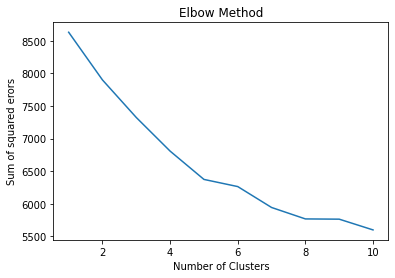

In [116]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# checking best k no using elbow

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(processed_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared erors')
plt.show()

C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

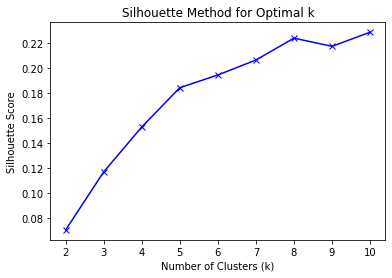

In [107]:
# score ranges from -1 (poor) to 1 (perfect clustering) best works on high cardinality data
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(processed_data)
    score = silhouette_score(processed_data, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [108]:
import umap

C:\Users\Twk14\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


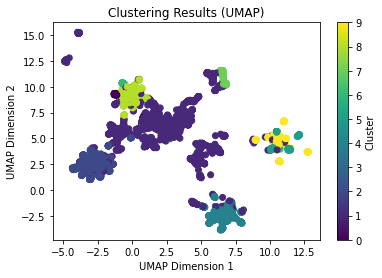

In [109]:
# Reduce to 2 dimensions using UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data_umap = reducer.fit_transform(processed_data)

plt.scatter(reduced_data_umap[:, 0], reduced_data_umap[:, 1], c=filtered_games_clu['Cluster_of_dev&Genres'], cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Clustering Results (UMAP)')
plt.colorbar(label='Cluster')
plt.show()

In [75]:
clusters = filtered_games_clu['Cluster_of_dev&Genres'].unique()
clusters

array([4, 1, 7, 6, 9, 8, 3, 2, 0, 5], dtype=int64)

In [76]:
print(filtered_games_clu['Cluster_of_dev&Genres'].unique())

[4 1 7 6 9 8 3 2 0 5]


In [110]:
# Loop through all rows to populate all 10 clusters 
for clust_id in range(10):  
    clust_members = filtered_games_clu[filtered_games_clu['Cluster_of_dev&Genres'] == clust_id]  
    print(f"Cluster {cluster_id}: {len(cluster_members)} members")
    print(cluster_members) 
    print("\n" + "-" * 50 + "\n")  

Cluster 9: 210 members
                  developers                   genres  Cluster_of_dev&Genres
205              ['Creobit']  ['Adventure', 'Casual']                      9
247          ['Somer Games']  ['Adventure', 'Casual']                      9
254              ['Creobit']  ['Adventure', 'Casual']                      9
255              ['Creobit']  ['Adventure', 'Casual']                      9
3036             ['Creobit']  ['Adventure', 'Casual']                      9
...                      ...                      ...                    ...
75673  ['William at Oxford']  ['Adventure', 'Casual']                      9
75828        ['Casual Arts']  ['Adventure', 'Casual']                      9
75829        ['Casual Arts']  ['Adventure', 'Casual']                      9
75893            ['Creobit']  ['Adventure', 'Casual']                      9
79886          ['Frontwing']  ['Adventure', 'Casual']                      9

[210 rows x 3 columns]

----------------------------